In [1]:
!pip install pandas numpy scikit-learn lightgbm xgboost matplotlib shap

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import seaborn as sns
import gc
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import re

In [3]:
data_dir = Path(r"D:\TR∆Ø·ªúNG T·ª∞ NHI√äN\DATA ANALYTICS\PROJECT\Home Credit Rick\Raw Data\home-credit-default-risk")
print((data_dir / "application_train.csv").exists())
print((data_dir / "application_test.csv").exists())

True
True


# Quick EDA

In [4]:
# ƒê·ªçc d·ªØ li·ªáu
train = pd.read_csv(data_dir / "application_train.csv")
test = pd.read_csv(data_dir / "application_test.csv")
print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()
test.head()

Train shape: (307511, 122)
Test shape: (48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

In [ ]:
# =========================
# 1. Ki·ªÉm tra bi·∫øn TARGET
# =========================
# TARGET l√† c·ªôt nh√£n (1 = kh√°ch h√†ng v·ª° n·ª£, 0 = tr·∫£ n·ª£ b√¨nh th∆∞·ªùng)
# 8% v·ª° n·ª£

print("Ph√¢n ph·ªëi TARGET:")
print(train["TARGET"].value_counts(normalize=True))

plt.figure(figsize=(5,4))
sns.countplot(data=train, x="TARGET")
plt.title("Ph√¢n ph·ªëi TARGET (0 = tr·∫£ n·ª£, 1 = v·ª° n·ª£)")
plt.show()

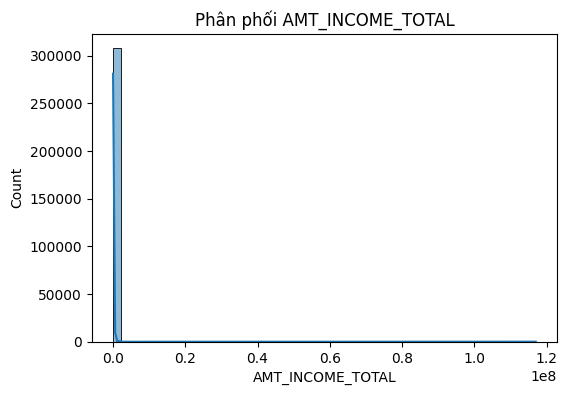

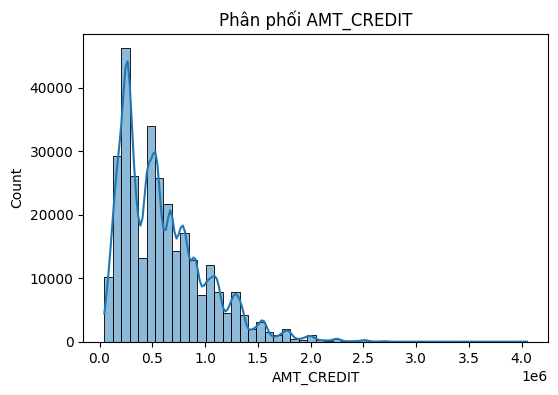

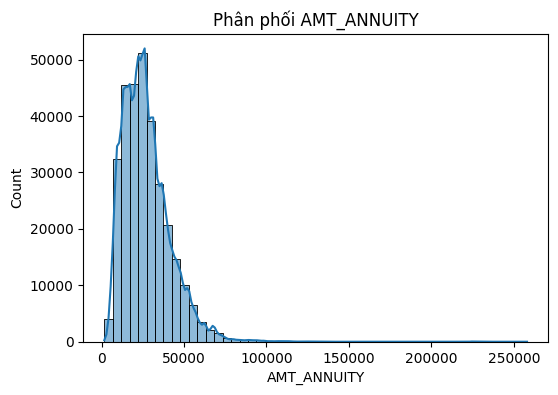

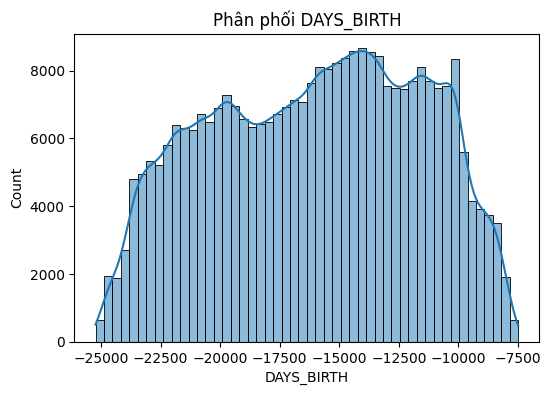

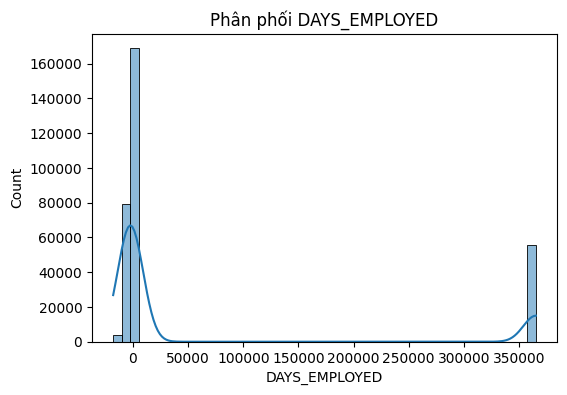

In [24]:
# =========================
# 2. M·ªôt s·ªë bi·∫øn s·ªë (numerical)
# =========================
num_cols = ["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "DAYS_BIRTH", "DAYS_EMPLOYED"]

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(train[col], bins=50, kde=True)
    plt.title(f"Ph√¢n ph·ªëi {col}")
    plt.show()

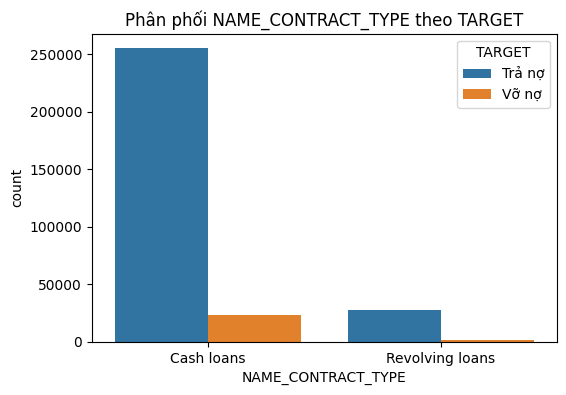

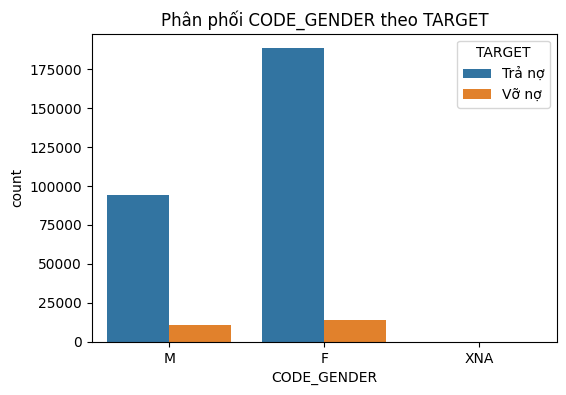

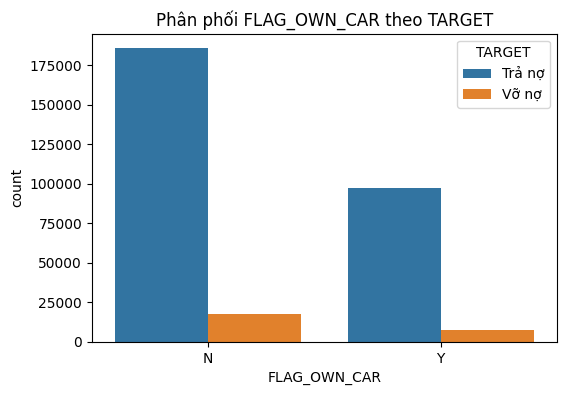

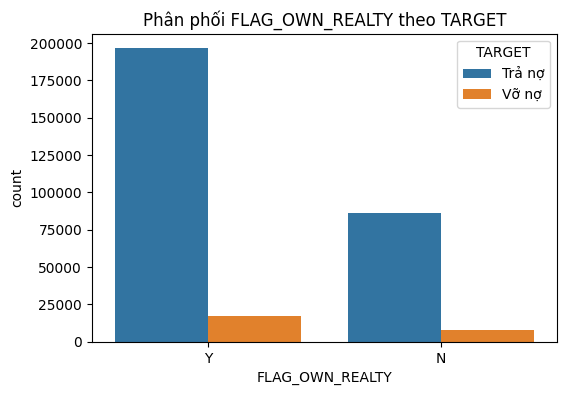

In [25]:
# =========================
# 3. M·ªôt s·ªë bi·∫øn ph√¢n lo·∫°i (categorical)
# =========================
cat_cols = ["NAME_CONTRACT_TYPE", "CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=train, x=col, hue="TARGET")
    plt.title(f"Ph√¢n ph·ªëi {col} theo TARGET")
    plt.legend(title="TARGET", labels=["Tr·∫£ n·ª£", "V·ª° n·ª£"])
    plt.show()

In [ ]:
# =========================
# 4. Quan h·ªá gi·ªØa AGE v√† TARGET
# =========================
# DAYS_BIRTH l√† s·ªë ng√†y √¢m -> chuy·ªÉn sang tu·ªïi
train["AGE"] = -train["DAYS_BIRTH"] / 365

plt.figure(figsize=(6,4))
sns.histplot(train, x="AGE", hue="TARGET", bins=50, kde=False, element="step", stat="density")
plt.title("Ph√¢n ph·ªëi AGE theo TARGET")
plt.show()

### üìä Nh·∫≠n x√©t bi·ªÉu ƒë·ªì:

- Bi·ªÉu ƒë·ªì TARGET: r·∫•t m·∫•t c√¢n b·∫±ng (~92% = 0, 8% = 1).

- Income, Credit, Annuity: c√≥ outlier (thu nh·∫≠p c·ª±c cao).

- Categorical: v√≠ d·ª• gi·ªõi t√≠nh (nam/n·ªØ) ph√¢n b·ªï kh√°c nhau theo TARGET.

- Age: kh√°ch h√†ng tr·∫ª tu·ªïi th∆∞·ªùng c√≥ t·ª∑ l·ªá v·ª° n·ª£ cao h∆°n.

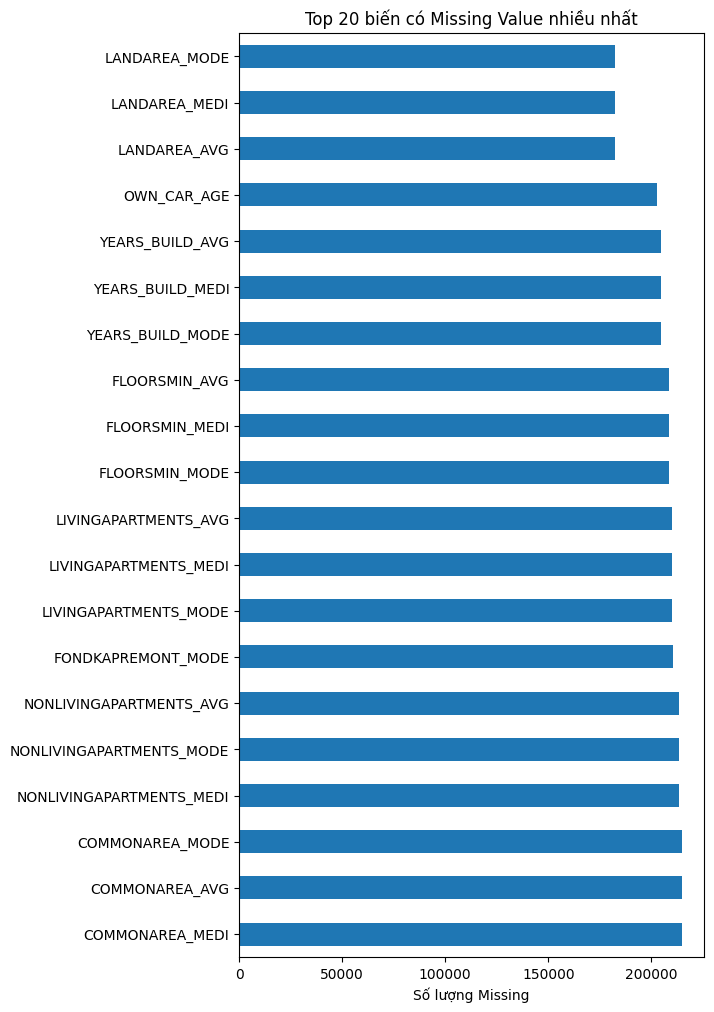

T·ª∑ l·ªá missing value cao nh·∫•t:
COMMONAREA_MEDI             69.872297
COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
NONLIVINGAPARTMENTS_MEDI    69.432963
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_MODE       68.354953
LIVINGAPARTMENTS_MEDI       68.354953
LIVINGAPARTMENTS_AVG        68.354953
dtype: float64


In [26]:
# ======================================
# 1. Ph√¢n t√≠ch Missing Values
# ======================================
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

plt.figure(figsize=(6,12))
missing[:20].plot(kind="barh")
plt.title("Top 20 bi·∫øn c√≥ Missing Value nhi·ªÅu nh·∫•t")
plt.xlabel("S·ªë l∆∞·ª£ng Missing")
plt.show()

print("T·ª∑ l·ªá missing value cao nh·∫•t:")
print((missing / len(train) * 100).head(10))

### üìä Gi·∫£i th√≠ch k·∫øt qu·∫£:

- Nhi·ªÅu c·ªôt c√≥ missing c·ª±c cao (v√≠ d·ª• OWN_CAR_AGE, OCCUPATION_TYPE, ho·∫∑c d·ªØ li·ªáu t·ª´ b·∫£ng con).

- B·∫°n c·∫ßn quy·∫øt ƒë·ªãnh:

    - Drop c·ªôt n·∫øu missing qu√° 40‚Äì50%.

    - Ho·∫∑c ƒëi·ªÅn gi√° tr·ªã trung v·ªã/mean/‚ÄúUnknown‚Äù.

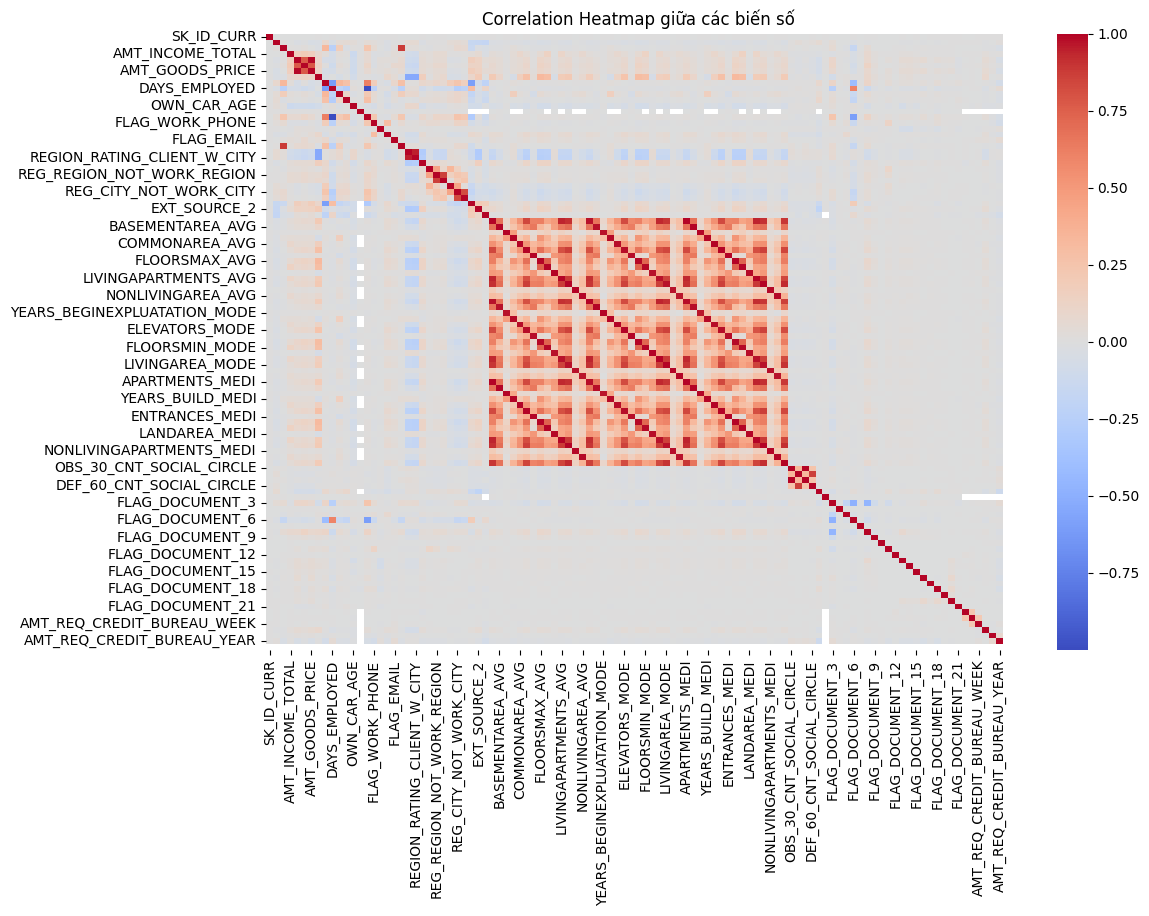

Top 10 bi·∫øn t∆∞∆°ng quan m·∫°nh nh·∫•t v·ªõi TARGET:
TARGET                         1.000000
EXT_SOURCE_3                  -0.178919
EXT_SOURCE_2                  -0.160472
EXT_SOURCE_1                  -0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
Name: TARGET, dtype: float64


In [27]:
# ======================================
# 2. Correlation Heatmap (bi·∫øn s·ªë)
# ======================================
# L·∫•y c√°c bi·∫øn s·ªë
numeric_cols = train.select_dtypes(include=["int64","float64"]).columns

# T√≠nh correlation v·ªõi TARGET
corr = train[numeric_cols].corr()

# Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap gi·ªØa c√°c bi·∫øn s·ªë")
plt.show()

# Xem top 10 bi·∫øn t∆∞∆°ng quan m·∫°nh nh·∫•t v·ªõi TARGET
corr_target = corr["TARGET"].sort_values(key=abs, ascending=False)
print("Top 10 bi·∫øn t∆∞∆°ng quan m·∫°nh nh·∫•t v·ªõi TARGET:")
print(corr_target.head(11))  # bao g·ªìm c·∫£ TARGET=1.0

### üìä Gi·∫£i th√≠ch k·∫øt qu·∫£:

- EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 th∆∞·ªùng c√≥ t∆∞∆°ng quan cao v·ªõi TARGET ‚Üí r·∫•t quan tr·ªçng.

- DAYS_BIRTH (tu·ªïi) c≈©ng th∆∞·ªùng c√≥ t∆∞∆°ng quan.

- C√°c bi·∫øn ti·ªÅn (AMT_CREDIT, AMT_INCOME_TOTAL) th∆∞·ªùng t∆∞∆°ng quan y·∫øu.

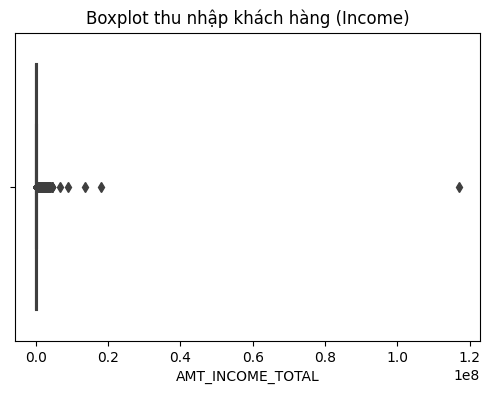

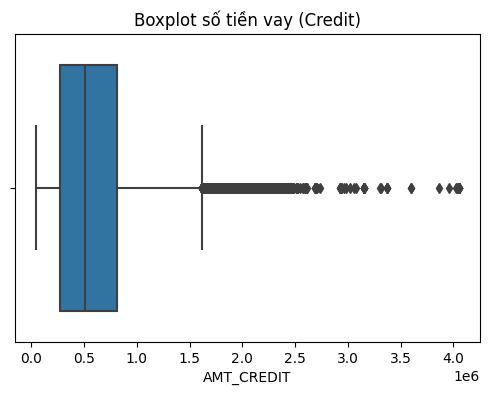

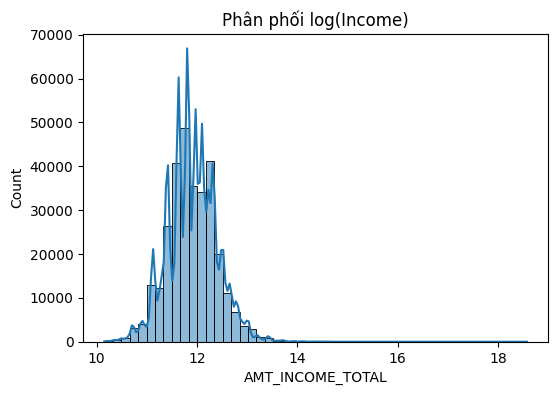

In [28]:
# ======================================
# 3. Ph√¢n t√≠ch Outliers (v√≠ d·ª• AMT_INCOME_TOTAL, AMT_CREDIT)
# ======================================
plt.figure(figsize=(6,4))
sns.boxplot(x=train["AMT_INCOME_TOTAL"])
plt.title("Boxplot thu nh·∫≠p kh√°ch h√†ng (Income)")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=train["AMT_CREDIT"])
plt.title("Boxplot s·ªë ti·ªÅn vay (Credit)")
plt.show()

# C√≥ th·ªÉ zoom v√†o b·∫±ng c√°ch log-transform ƒë·ªÉ d·ªÖ nh√¨n
import numpy as np
plt.figure(figsize=(6,4))
sns.histplot(np.log1p(train["AMT_INCOME_TOTAL"]), bins=50, kde=True)
plt.title("Ph√¢n ph·ªëi log(Income)")
plt.show()

### üìä Gi·∫£i th√≠ch k·∫øt qu·∫£:

- AMT_INCOME_TOTAL c√≥ outlier c·ª±c l·ªõn (thu nh·∫≠p h√†ng trƒÉm tri·ªáu USD).

- N√™n d√πng log-transform ƒë·ªÉ gi·∫£m skewness.

- C√≥ th·ªÉ clip gi√° tr·ªã c·ª±c ƒëoan (top 99%).

# X·ª≠ l√Ω d·ªØ li·ªáu n·ªÅn (Application)

In [5]:
# G·ªôp train + test ƒë·ªÉ one-hot encode cho ƒë·ªìng nh·∫•t.
# One-hot encode c√°c c·ªôt ph√¢n lo·∫°i (object).
# Gi·ªØ l·∫°i TARGET ri√™ng ra.
# Gi·ªØ l·∫°i TARGET
y = train["TARGET"].reset_index(drop=True).copy()

# ƒê√°nh d·∫•u train/test
train["is_train"] = 1
test["is_train"] = 0

# B·ªè c·ªôt TARGET kh·ªèi train ƒë·ªÉ n·ªëi v√†o test
train_ = train.drop(columns=["TARGET"]).reset_index(drop=True)
test = test.reset_index(drop=True)
app = pd.concat([train_, test], axis=0, ignore_index=True)

print("App shape before OHE:", app.shape)

# One-hot encode c√°c c·ªôt ph√¢n lo·∫°i
app = pd.get_dummies(app, dummy_na=True)
print("App shape after OHE:", app.shape)

# T√°ch l·∫°i train/test
app_train = app[app["is_train"] == 1].drop(columns=["is_train"]).reset_index(drop=True)
app_test  = app[app["is_train"] == 0].drop(columns=["is_train"]).reset_index(drop=True)
print("Final train:", app_train.shape, " test:", app_test.shape)

App shape before OHE: (356255, 122)
App shape after OHE: (356255, 262)
Final train: (307511, 261)  test: (48744, 261)


# Feature engineering theo kh√°ch h√†ng (SK_ID_CURR)

In [6]:
# bureau_balance.csv: L·ªãch s·ª≠ t√≠n d·ª•ng chi ti·∫øt h√†ng th√°ng cho t·ª´ng kho·∫£n vay (status = ƒë√∫ng h·∫°n, tr·ªÖ h·∫°n, ƒë√≥ng, ‚Ä¶)
# ƒê·ªçc d·ªØ li·ªáu bureau_balance
bb = pd.read_csv(r"D:\TR∆Ø·ªúNG T·ª∞ NHI√äN\DATA ANALYTICS\PROJECT\Home Credit Rick\Raw Data\bureau_balance.csv")
print("Bureau Balance shape:", bb.shape)
print(bb.head())

# One-hot encode c·ªôt STATUS
bb = pd.get_dummies(bb, columns=["STATUS"], dummy_na=True)

# G·ªôp theo SK_ID_BUREAU
bb_agg = bb.groupby("SK_ID_BUREAU").agg(["min","max","mean","sum","size"])
bb_agg.columns = ["BB_" + "_".join(col).strip() for col in bb_agg.columns.values]

print("Bureau Balance agg shape:", bb_agg.shape)
# print(bb_agg.head())

# ƒê·ªçc bureau.csv
bureau = pd.read_csv(r"D:\TR∆Ø·ªúNG T·ª∞ NHI√äN\DATA ANALYTICS\PROJECT\Home Credit Rick\Raw Data\bureau.csv")

# Merge v√†o bureau
bureau = bureau.merge(bb_agg, how="left", on="SK_ID_BUREAU")
print("Bureau shape after merge:", bureau.shape)

Bureau Balance shape: (27299925, 3)
   SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C
Bureau Balance agg shape: (817395, 50)
Bureau shape after merge: (1716428, 67)


### üîπ √ù nghƒ©a feature m·ªõi

- BB_MONTHS_BALANCE_MIN: s·ªë th√°ng l√¢u nh·∫•t m√† c√≥ record cho kho·∫£n vay (v√≠ d·ª• -60 = 5 nƒÉm tr∆∞·ªõc).

- BB_STATUS_0_SUM: t·ªïng s·ªë th√°ng kho·∫£n vay tr·∫£ ƒë√∫ng h·∫°n.

- BB_STATUS_1_SUM: t·ªïng s·ªë th√°ng tr·ªÖ h·∫°n 1‚Äì30 ng√†y.

- BB_STATUS_5_SUM: t·ªïng s·ªë th√°ng n·ª£ x·∫•u >180 ng√†y.

- BB_STATUS_C_SUM: s·ªë th√°ng kho·∫£n vay ƒë√£ ƒë√≥ng.

### üëâ C√°c feature n√†y ph·∫£n √°nh l·ªãch s·ª≠ t√≠n d·ª•ng chi ti·∫øt ‚Üí c·ª±c k·ª≥ quan tr·ªçng ƒë·ªÉ d·ª± ƒëo√°n r·ªßi ro.

In [7]:
# bureau.csv: ch·ª©a th√¥ng tin c√°c kho·∫£n vay tr∆∞·ªõc ƒë√¢y c·ªßa kh√°ch h√†ng t·∫°i nh·ªØng t·ªï ch·ª©c t√≠n d·ª•ng kh√°c.
# One-hot encode bureau (sau khi merge bb)
bureau = pd.get_dummies(bureau, dummy_na=True)

# Group theo SK_ID_CURR
bureau_agg = bureau.groupby("SK_ID_CURR").agg(["min","max","mean","sum","var"])

# ƒê·∫∑t t√™n l·∫°i c·ªôt
bureau_agg.columns = ["BUREAU_" + "_".join(col).strip() for col in bureau_agg.columns.values]

print("Bureau agg shape:", bureau_agg.shape)

# Merge v√†o app_train v√† app_test
app_train = app_train.merge(bureau_agg, how="left", on="SK_ID_CURR")
app_test  = app_test.merge(bureau_agg, how="left", on="SK_ID_CURR")

print("App train:", app_train.shape, " App test:", app_test.shape)

Bureau agg shape: (305811, 445)
App train: (307511, 706)  App test: (48744, 706)


### üîπ √ù nghƒ©a feature m·ªõi

V√≠ d·ª• v√†i c·ªôt sau khi aggregate:

BUREAU_AMT_CREDIT_SUM_DEBT_MEAN: trung b√¨nh s·ªë n·ª£ c√≤n l·∫°i c·ªßa kh√°ch h√†ng t·∫°i c√°c kho·∫£n vay b√™n ngo√†i.

BUREAU_DAYS_CREDIT_MIN: kho·∫£n vay xa nh·∫•t trong qu√° kh·ª© (t√≠nh theo ng√†y).

BUREAU_CREDIT_ACTIVE_Active_SUM: s·ªë kho·∫£n vay ƒëang ho·∫°t ƒë·ªông.

BUREAU_BB_STATUS_5_SUM: t·ªïng s·ªë th√°ng b·ªã n·ª£ x·∫•u (l·∫•y t·ª´ bureau_balance).

üëâ Nh·ªù c√°c feature n√†y, model bi·∫øt kh√°ch h√†ng vay ·ªü n∆°i kh√°c c√≥ l·ªãch s·ª≠ t·ªët hay x·∫•u.

In [ ]:
# previous_application.csv: to√†n b·ªô c√°c ƒë∆°n vay tr∆∞·ªõc ƒë√¢y c·ªßa kh√°ch h√†ng t·∫°i Home Credit.
# Load d·ªØ li·ªáu
previous = pd.read_csv(r"D:\TR∆Ø·ªúNG T·ª∞ NHI√äN\DATA ANALYTICS\PROJECT\Home Credit Rick\Raw Data\previous_application.csv")
print("Previous shape:", previous.shape)
print(previous[["SK_ID_CURR","SK_ID_PREV","NAME_CONTRACT_TYPE","AMT_APPLICATION","AMT_CREDIT","NAME_CONTRACT_STATUS"]].head())

# One-hot encode c√°c bi·∫øn ph√¢n lo·∫°i
previous = pd.get_dummies(previous, dummy_na=True)

# Group theo SK_ID_CURR
prev_agg = previous.groupby("SK_ID_CURR").agg(["min","max","mean","sum","var"])
prev_agg.columns = ["PREV_" + "_".join(col).strip() for col in prev_agg.columns.values]

print("Previous agg shape:", prev_agg.shape)

# Merge v√†o app_train v√† app_test
app_train = app_train.merge(prev_agg, how="left", on="SK_ID_CURR")
app_test  = app_test.merge(prev_agg, how="left", on="SK_ID_CURR")

print("App train:", app_train.shape, " App test:", app_test.shape)

üîπ √ù nghƒ©a feature m·ªõi

PREV_AMT_APPLICATION_MEAN: trung b√¨nh s·ªë ti·ªÅn kh√°ch h√†ng t·ª´ng y√™u c·∫ßu vay.

PREV_NAME_CONTRACT_STATUS_Refused_SUM: s·ªë l·∫ßn b·ªã t·ª´ ch·ªëi.

PREV_NAME_CONTRACT_STATUS_Approved_SUM: s·ªë l·∫ßn ƒë∆∞·ª£c duy·ªát.

PREV_AMT_CREDIT_MAX: s·ªë ti·ªÅn vay l·ªõn nh·∫•t t·ª´ng ƒë∆∞·ª£c c·∫•p.

üëâ T·∫•t c·∫£ nh·ªØng c√°i n√†y gi√∫p model h·ªçc v·ªÅ l·ªãch s·ª≠ vay c≈© ·∫£nh h∆∞·ªüng t·ªõi r·ªßi ro t√≠n d·ª•ng hi·ªán t·∫°i.

In [ ]:
# installments_payments.csv: Ghi l·∫°i l·ªãch s·ª≠ tr·∫£ g√≥p c·ªßa kh√°ch h√†ng cho t·ª´ng kho·∫£n vay tr∆∞·ªõc (SK_ID_PREV)
# ƒê·ªçc file installments
ins = pd.read_csv(r"D:\TR∆Ø·ªúNG T·ª∞ NHI√äN\DATA ANALYTICS\PROJECT\Home Credit Rick\Raw Data\installments_payments.csv")
print("Installments shape:", ins.shape)
print(ins.head())

# Feature m·ªõi: ng√†y tr·ªÖ h·∫°n (√¢m = tr·∫£ s·ªõm, d∆∞∆°ng = tr·∫£ tr·ªÖ)
ins["DAYS_LATE"] = ins["DAYS_ENTRY_PAYMENT"] - ins["DAYS_INSTALMENT"]

# Feature m·ªõi: ch√™nh l·ªách ti·ªÅn tr·∫£
ins["AMT_DIFF"] = ins["AMT_PAYMENT"] - ins["AMT_INSTALMENT"]

# Group theo kh√°ch h√†ng
ins_agg = ins.groupby("SK_ID_CURR").agg(["min","max","mean","sum","var"])
ins_agg.columns = ["INS_" + "_".join(col).strip() for col in ins_agg.columns.values]

print("Installments agg shape:", ins_agg.shape)

# Merge v√†o app
app_train = app_train.merge(ins_agg, how="left", on="SK_ID_CURR")
app_test  = app_test.merge(ins_agg, how="left", on="SK_ID_CURR")

print("App train:", app_train.shape, " App test:", app_test.shape)

üîπ √ù nghƒ©a feature m·ªõi

INS_DAYS_LATE_MEAN: trung b√¨nh s·ªë ng√†y kh√°ch h√†ng tr·∫£ tr·ªÖ.

INS_AMT_DIFF_SUM: t·ªïng s·ªë ti·ªÅn tr·∫£ th·ª´a (d∆∞∆°ng) ho·∫∑c thi·∫øu (√¢m).

INS_AMT_PAYMENT_MEAN: trung b√¨nh s·ªë ti·ªÅn m·ªói k·ª≥ kh√°ch h√†ng th·ª±c tr·∫£.

INS_AMT_INSTALMENT_SUM: t·ªïng s·ªë ti·ªÅn kh√°ch h√†ng ƒë√£ t·ª´ng ph·∫£i tr·∫£.

üëâ ƒê√¢y l√† feature r·∫•t quan tr·ªçng, v√¨ n√≥ ph·∫£n √°nh th√≥i quen tr·∫£ n·ª£ th·ª±c t·∫ø.

In [ ]:
# POS_CASH_balance.csv: Ghi l·∫°i l·ªãch s·ª≠ kho·∫£n vay tr·∫£ g√≥p / th·∫ª t√≠n d·ª•ng tr·∫£ g√≥p t·∫°i ƒëi·ªÉm b√°n.
# ƒê·ªçc file POS_CASH_balance
pos = pd.read_csv(r"D:\TR∆Ø·ªúNG T·ª∞ NHI√äN\DATA ANALYTICS\PROJECT\Home Credit Rick\Raw Data\POS_CASH_balance.csv")
print("POS shape:", pos.shape)
print(pos.head())

# OHE cho c·ªôt tr·∫°ng th√°i h·ª£p ƒë·ªìng
pos = pd.get_dummies(pos, columns=["NAME_CONTRACT_STATUS"], dummy_na=True)

# Group theo SK_ID_PREV (t·ª©c l√† m·ªói kho·∫£n vay)
pos_agg = pos.groupby("SK_ID_PREV").agg(["min", "max", "mean", "size"])
pos_agg.columns = ["POS_" + "_".join(col).strip() for col in pos_agg.columns.values]

print("POS agg by SK_ID_PREV:", pos_agg.shape)

# Merge v√†o previous_application ƒë·ªÉ √°nh x·∫° SK_ID_PREV -> SK_ID_CURR
prev = pd.read_csv(r"D:\TR∆Ø·ªúNG T·ª∞ NHI√äN\DATA ANALYTICS\PROJECT\Home Credit Rick\Raw Data\previous_application.csv")[["SK_ID_PREV","SK_ID_CURR"]]
pos_merged = pos_agg.merge(prev, on="SK_ID_PREV", how="left")

# B·ªè SK_ID_PREV ƒë·ªÉ ch·ªâ c√≤n SK_ID_CURR
pos_merged = pos_merged.drop(columns=["SK_ID_PREV"])

# Group ti·∫øp theo SK_ID_CURR
pos_final = pos_merged.groupby("SK_ID_CURR").agg(["min", "max", "mean", "sum", "var"])
pos_final.columns = ["POS_" + "_".join(col).strip() for col in pos_final.columns.values]

print("POS final agg by SK_ID_CURR:", pos_final.shape)

# Merge v√†o app
app_train = app_train.merge(pos_final, how="left", on="SK_ID_CURR")
app_test  = app_test.merge(pos_final, how="left", on="SK_ID_CURR")

print("App train:", app_train.shape, " App test:", app_test.shape)

üîπ √ù nghƒ©a feature m·ªõi

POS_MONTHS_BALANCE_MIN: s·ªë th√°ng xa nh·∫•t kh√°ch h√†ng t·ª´ng c√≥ kho·∫£n vay POS (th∆∞·ªùng l√† √¢m l·ªõn ‚Üí vay t·ª´ l√¢u).

POS_CNT_INSTALMENT_FUTURE_MEAN: trung b√¨nh s·ªë k·ª≥ tr·∫£ g√≥p c√≤n l·∫°i.

POS_NAME_CONTRACT_STATUS_Completed_MEAN: t·ª∑ l·ªá kho·∫£n vay ƒë√£ ho√†n th√†nh.

POS_NAME_CONTRACT_STATUS_Active_MEAN: t·ª∑ l·ªá kho·∫£n vay c√≤n ƒëang ho·∫°t ƒë·ªông.

POS_size: s·ªë th√°ng kh√°ch h√†ng xu·∫•t hi·ªán trong POS (k·ª≥ h·∫°n d√†i h∆°n = nhi·ªÅu d√≤ng h∆°n).

In [ ]:
# credit_card_balance.csv: D·ªØ li·ªáu c√¢n ƒë·ªëi h√†ng th√°ng cho t·ª´ng th·∫ª t√≠n d·ª•ng c·ªßa kh√°ch h√†ng (kh√¥ng ph·∫£i kho·∫£n vay POS)
# ƒê·ªçc file credit_card_balance
cc = pd.read_csv(r"D:\TR∆Ø·ªúNG T·ª∞ NHI√äN\DATA ANALYTICS\PROJECT\Home Credit Rick\Raw Data\credit_card_balance.csv")
print("Credit card balance shape:", cc.shape)
print(cc.head())

# One-hot encode bi·∫øn ph√¢n lo·∫°i
cc = pd.get_dummies(cc, columns=["NAME_CONTRACT_STATUS"], dummy_na=True)

# Group theo SK_ID_PREV tr∆∞·ªõc
cc_agg_prev = cc.groupby("SK_ID_PREV").agg([
    "min", "max", "mean", "sum", "var"
])

# L√†m ph·∫≥ng t√™n c·ªôt
cc_agg_prev.columns = ["CC_" + "_".join(col).upper() for col in cc_agg_prev.columns.values]

# ƒê·ªçc √°nh x·∫° SK_ID_PREV -> SK_ID_CURR
prev_map = pd.read_csv(r"D:\TR∆Ø·ªúNG T·ª∞ NHI√äN\DATA ANALYTICS\PROJECT\Home Credit Rick\Raw Data\previous_application.csv")[["SK_ID_PREV", "SK_ID_CURR"]]

# G·∫Øn SK_ID_CURR v√†o cc_agg_prev
cc_agg = cc_agg_prev.merge(prev_map, on="SK_ID_PREV", how="left")

# Group l·∫ßn 2 theo kh√°ch h√†ng
cc_final = cc_agg.groupby("SK_ID_CURR").agg(["min", "max", "mean", "sum", "var"])
cc_final.columns = ["CC_" + "_".join(col).upper() for col in cc_final.columns.values]

print("Credit card features shape:", cc_final.shape)

# Merge v√†o app_train v√† app_test
app_train = app_train.merge(cc_final, how="left", on="SK_ID_CURR")
app_test  = app_test.merge(cc_final, how="left", on="SK_ID_CURR")

print("App train:", app_train.shape, "App test:", app_test.shape)

# D·ªçn RAM
del cc, cc_agg_prev, cc_agg, prev_map, cc_final
gc.collect()

üîπ √ù nghƒ©a feature m·ªõi
CC_AMT_BALANCE_MEAN: s·ªë d∆∞ trung b√¨nh tr√™n th·∫ª.

CC_AMT_CREDIT_LIMIT_ACTUAL_MAX: h·∫°n m·ª©c th·∫ª cao nh·∫•t t·ª´ng c√≥.

CC_AMT_DRAWINGS_CURRENT_SUM: t·ªïng ti·ªÅn ƒë√£ r√∫t (ti√™u x√†i).

CC_CNT_DRAWINGS_ATM_CURRENT_MEAN: trung b√¨nh s·ªë l·∫ßn r√∫t ti·ªÅn m·∫∑t qua ATM.

CC_NAME_CONTRACT_STATUS_Active_MEAN: t·ª∑ l·ªá th√°ng th·∫ª ·ªü tr·∫°ng th√°i Active.

# Machine Learning

## Chu·∫©n b·ªã d·ªØ li·ªáu

In [14]:
def clean_column_names(df):
    df = df.copy()
    df.columns = [
        re.sub(r'[^A-Za-z0-9_]+', '_', col)  # thay k√Ω t·ª± ƒë·∫∑c bi·ªát b·∫±ng "_"
        for col in df.columns
    ]
    return df

X_train = clean_column_names(X_train)
X_valid = clean_column_names(X_valid)
X_test  = clean_column_names(X_test)

In [15]:
# Sau khi merge/g·ªôp xong h·∫øt
app_train = clean_column_names(app_train)
app_test  = clean_column_names(app_test)

# L·∫•y nh√£n t·ª´ file train g·ªëc
labels = train[["SK_ID_CURR", "TARGET"]].set_index("SK_ID_CURR")

# CƒÉn ch·ªânh y theo ƒë√∫ng th·ª© t·ª± h√†ng c·ªßa app_train
y = labels.loc[app_train["SK_ID_CURR"], "TARGET"].values

# X v√† X_test KH√îNG drop TARGET n·ªØa (v√¨ kh√¥ng c√≥ c·ªôt n√†y trong app_train/app_test)
X = app_train.drop(columns=["SK_ID_CURR"])
X_test = app_test.drop(columns=["SK_ID_CURR"])

# ƒêi·ªÅn missing
X = X.fillna(-999)
X_test = X_test.fillna(-999)

# sanity check
assert len(y) == len(X)

## Baseline model (Logistic Regression)  

In [16]:
# Train/valid split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression baseline
log_reg = LogisticRegression(max_iter=1000, solver="lbfgs")
log_reg.fit(X_train, y_train)

# Predict
y_pred = log_reg.predict_proba(X_valid)[:,1]
auc_baseline = roc_auc_score(y_valid, y_pred)

print("Baseline Logistic Regression AUC:", auc_baseline)

Baseline Logistic Regression AUC: 0.5


## Model ch√≠nh (LightGBM) 

In [17]:
# T·∫°o Dataset cho LightGBM
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid)

# Th√¥ng s·ªë model
model = LGBMClassifier(
    objective="binary",
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    random_state=42, 
    #n_estimators=10000
)

# Train v·ªõi callbacks
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_metric="auc",
    callbacks=[early_stopping(stopping_rounds=200), log_evaluation(200)]
)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.028240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Lig

LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.8,
               learning_rate=0.05, objective='binary', random_state=42)

##  Cross Validation (K-Fold)

In [18]:
# Kh·ªüi t·∫°o KFold
folds = KFold(n_splits=5, shuffle=True, random_state=42)

# M·∫£ng l∆∞u k·∫øt qu·∫£
oof_preds = np.zeros(len(X))
sub_preds = np.zeros(len(X_test))

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    print(f"\n===== Fold {n_fold+1} =====")
    
    # T√°ch train/valid theo index
    train_x, train_y = X.iloc[train_idx], y[train_idx]
    valid_x, valid_y = X.iloc[valid_idx], y[valid_idx]
    
    # Kh·ªüi t·∫°o model
    model = LGBMClassifier(
        objective="binary",
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        random_state=42,
        #n_estimators=10000   # c·∫ßn cho early stopping
    )
    
    # Train
    model.fit(
        train_x, train_y,
        eval_set=[(train_x, train_y), (valid_x, valid_y)],
        eval_metric="auc",
        callbacks=[early_stopping(200), log_evaluation(200)]
    )
    
    # L∆∞u OOF predictions
    oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
    
    # L∆∞u test predictions (trung b√¨nh qua folds)
    sub_preds += model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1] / folds.n_splits


===== Fold 1 =====
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.413740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59484
[LightGBM] [I

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.368946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59430
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 685
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080977 -> initscore=-2.429150
[LightGBM] [Info] Start training from score -2.429150
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.785058	training's binary_logloss: 0.239427	valid_1's auc: 0.756122	valid_1's binary_logloss

## Feature Importance (LightGBM)

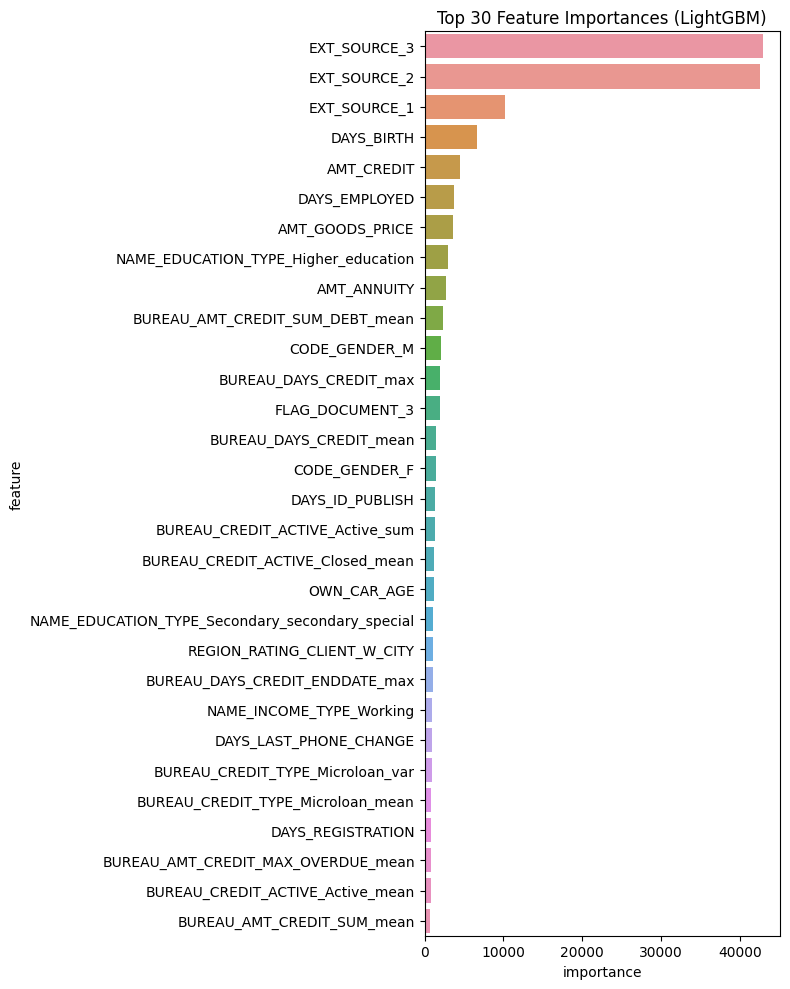

In [20]:
# Sau v√≤ng for KFold, l·∫•y booster t·ª´ model cu·ªëi c√πng
booster = model.booster_

feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = booster.feature_name()
feature_importance_df["importance"] = booster.feature_importance(importance_type="gain")

# Top 30 features
top_feats = feature_importance_df.sort_values("importance", ascending=False).head(30)

plt.figure(figsize=(8,10))
sns.barplot(x="importance", y="feature", data=top_feats)
plt.title("Top 30 Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()

##  D·ª± ƒëo√°n tr√™n test + Submission

In [23]:
# T√≠nh AUC tr√™n to√†n b·ªô OOF
cv_auc = roc_auc_score(y, oof_preds)
print(f"CV AUC (OOF): {cv_auc:.6f}")

CV AUC (OOF): 0.757585


In [22]:
submission = app_test[["SK_ID_CURR"]].copy()
submission["TARGET"] = sub_preds
submission.to_csv(r"D:\TR∆Ø·ªúNG T·ª∞ NHI√äN\DATA ANALYTICS\PROJECT\Home Credit Rick\Output\submission.csv", index=False)